In [1]:
# 패키지 로딩하기
import os
import numpy as np
import IPython.display as ipd
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
import librosa
import librosa.display

#### 1. 1차원 Waveform 데이터를 이용한 모델 만들어서 학습시키기

In [2]:
# 데이터 불러오기
data_path                 = os.getenv("HOME") + "/aiffel/speech_recognition/data/speech_wav_8000.npz"
data_speech               = np.load(data_path)

In [3]:
# 데이터 확인하기 (shape)
print("Wave data shape :",  data_speech["wav_vals"][:30000].shape)
print("Label data shape :", data_speech["label_vals"][:30000].shape)

Wave data shape : (30000, 8000)
Label data shape : (30000, 1)


In [4]:
# 데이터 확인하기 (랜덤하게 한개의 표본 추출) - 실행할 때 마다 뽑히는 데이터가 다름

# 랜덤하게 데이터 선택하기
rand = random.randint(0, len(data_speech["wav_vals"][:30000]))
print("rand number :", rand)                           # 랜덤숫자(정수) 확인

sr    = 8000                                           # 1초동안 재생되는 샘플의 갯수
data  = data_speech["wav_vals"][rand]                  # 랜덤숫자에 해당하는 인덱스를 가진 데이터 불러오기
# label = data_speech["label_vals"][rand]                # 랜덤숫자에 해당하는 인덱스를 가진 라벨 불러오기 
print("Wave data shape :", data.shape)                 # 뽑힌 데이터 shape 확인하기
print("label :", data_speech["label_vals"][rand])      # 뽑힌 데이터 label 확인하기

ipd.Audio(data, rate = sr)                             # 선택된 데이터 소리 들어보기

rand number : 21830
Wave data shape : (8000,)
label : ['down']


In [5]:
# 데이터 전처리 (label을 정의하고 데이터화 하기)
label_value = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value.append('unknown')             # label에 unknown 추가하기
label_value.append('silence')             # label에 silence 추가하기

print("LABEL :", label_value)             # label 전부 출력하기

new_label_value = dict()                  # 빈 딕셔너리 만들기
for i, l in enumerate(label_value):
    new_label_value[l] = i                  # label마다 key값 부여
label_value = new_label_value               # 덮어쓰기

print("indexed LABEL :", new_label_value)   # new_label_value 확인하기

temp = []                                   # 빈 리스트 만들기
for v in data_speech["label_vals"][:30000]: 
    temp.append(label_value[v[0]])          # label을 데이터화 하기
label_data = np.array(temp)                 # 데이터화 된 label을 덮어쓰기

label_data                                  # 데이터화 된 label 확인하기

LABEL : ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
indexed LABEL : {'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'on': 6, 'off': 7, 'stop': 8, 'go': 9, 'unknown': 10, 'silence': 11}


array([3, 3, 3, ..., 7, 7, 7])

In [6]:
### 데이터 분리하기
sr    = 8000
train_wav, test_wav, train_label, test_label = train_test_split(data_speech["wav_vals"][:30000], label_data, test_size = 0.2, shuffle = True)

# CNN을 위해 channel 추가하기
train_wav = train_wav.reshape([-1, sr, 1])
test_wav  = test_wav.reshape([-1, sr, 1])

# 분리된 데이터 확인하기
print("train data :",  train_wav.shape)
print("train label :", train_label.shape)
print("test data :",   test_wav.shape)
print("test label :",  test_label.shape)

train data : (24000, 8000, 1)
train label : (24000,)
test data : (6000, 8000, 1)
test label : (6000,)


In [7]:
# 하이퍼 파라미터 설정하기
batch_size     = 32
max_epochs     = 10
checkpoint_dir = os.getenv("HOME") + "/aiffel/speech_recognition/models/wav"

In [8]:
# data setting
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth = 12)
    return wav, label

In [9]:
# train data
train_dataset = tf.data.Dataset.from_tensor_slices((train_wav, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size = batch_size)
print(train_dataset)

# test data
test_dataset = tf.data.Dataset.from_tensor_slices((test_wav, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size = batch_size)
print(test_dataset)

<BatchDataset shapes: ((None, 8000, 1), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 8000, 1), (None, 12)), types: (tf.float32, tf.float32)>


In [10]:
# Wave Classification 모델 구현 - 기본 버전
input_tensor  = tf.keras.Input(shape = (sr, 1))

# 1계층
model_temp    = tf.keras.layers.Conv1D(32, 9, padding = "same", activation = "relu")(input_tensor)
model_temp    = tf.keras.layers.Conv1D(32, 9, padding = "same", activation = "relu")(model_temp)
model_temp    = tf.keras.layers.MaxPool1D()(model_temp)

# 2계층
model_temp    = tf.keras.layers.Conv1D(64, 9, padding = "same", activation = "relu")(model_temp)
model_temp    = tf.keras.layers.Conv1D(64, 9, padding = "same", activation = "relu")(model_temp)
model_temp    = tf.keras.layers.MaxPool1D()(model_temp)

# 3계층
model_temp    = tf.keras.layers.Conv1D(128, 9, padding = "same", activation = "relu")(model_temp)
model_temp    = tf.keras.layers.Conv1D(128, 9, padding = "same", activation = "relu")(model_temp)
model_temp    = tf.keras.layers.Conv1D(128, 9, padding = "same", activation = "relu")(model_temp)
model_temp    = tf.keras.layers.MaxPool1D()(model_temp)

# 4계층
model_temp    = tf.keras.layers.Conv1D(256, 9, padding = "same", activation = "relu")(model_temp)
model_temp    = tf.keras.layers.Conv1D(256, 9, padding = "same", activation = "relu")(model_temp)
model_temp    = tf.keras.layers.Conv1D(256, 9, padding = "same", activation = "relu")(model_temp)
model_temp    = tf.keras.layers.MaxPool1D()(model_temp)
model_temp    = tf.keras.layers.Dropout(0.3)(model_temp)

# 5계층
model_temp    = tf.keras.layers.Flatten()(model_temp)
model_temp    = tf.keras.layers.Dense(256)(model_temp)
model_temp    = tf.keras.layers.BatchNormalization()(model_temp)
model_temp    = tf.keras.layers.Activation("relu")(model_temp)

output_tensor = tf.keras.layers.Dense(12)(model_temp)

model_wav     = tf.keras.Model(input_tensor, output_tensor)

model_wav.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 8000, 32)          320       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 8000, 32)          9248      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 4000, 32)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 4000, 64)          18496     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 4000, 64)          36928     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2000, 64)          0     

In [11]:
# model compile
model_wav.compile(loss      = tf.keras.losses.CategoricalCrossentropy(from_logits = True), 
                  optimizer = tf.keras.optimizers.Adam(1e-4), 
                  metrics   = ["accuracy"])

# callback 지정하기
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir, 
                                                 save_weights_only = True, 
                                                 monitor           = "val_loss", 
                                                 mode              = "auto", 
                                                 save_best_only    = True,
                                                 verbose           = 1)

# 모델 학습시키기
history = model_wav.fit(train_dataset, 
                        epochs           = max_epochs, 
                        steps_per_epoch  = len(train_wav) // batch_size,
                        validation_data  = test_dataset,
                        validation_steps = len(test_wav) // batch_size,
                        callbacks        = [cp_callback])

Epoch 1/10
750/750 [==============================] - ETA: 0s - loss: 1.5279 - accuracy: 0.4661
Epoch 00001: val_loss improved from inf to 1.32723, saving model to /home/aiffel-dj52/aiffel/speech_recognition/models/wav
750/750 [==============================] - 79s 106ms/step - loss: 1.5279 - accuracy: 0.4661 - val_loss: 1.3272 - val_accuracy: 0.5286
Epoch 2/10
750/750 [==============================] - ETA: 0s - loss: 0.8996 - accuracy: 0.7046
Epoch 00002: val_loss improved from 1.32723 to 0.86581, saving model to /home/aiffel-dj52/aiffel/speech_recognition/models/wav
750/750 [==============================] - 80s 106ms/step - loss: 0.8996 - accuracy: 0.7046 - val_loss: 0.8658 - val_accuracy: 0.7086
Epoch 3/10
750/750 [==============================] - ETA: 0s - loss: 0.6753 - accuracy: 0.7873
Epoch 00003: val_loss improved from 0.86581 to 0.59637, saving model to /home/aiffel-dj52/aiffel/speech_recognition/models/wav
750/750 [==============================] - 80s 107ms/step - loss: 0

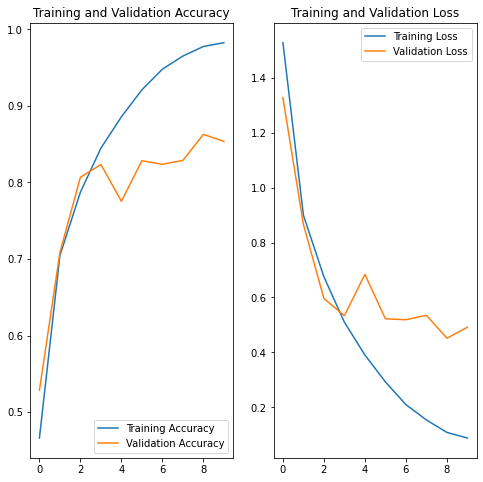

In [12]:
# 학습 결과 보기
acc          = history.history["accuracy"]
val_acc      = history.history["val_accuracy"]
loss         = history.history["loss"]
val_loss     = history.history["val_loss"]
epochs_range = range(len(acc))

plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc,     label = "Training Accuracy")
plt.plot(epochs_range, val_acc, label = "Validation Accuracy")
plt.legend(loc = "lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss,     label = "Training Loss")
plt.plot(epochs_range, val_loss, label = "Validation Loss")
plt.legend(loc = "upper right")
plt.title("Training and Validation Loss")
plt.show()

In [13]:
# model 평가하기
model_wav.load_weights(checkpoint_dir)
results = model_wav.evaluate(test_dataset)

print("loss value : {:.3f}".format(results[0]))
print("accuracy value : {:.4f}%".format(results[1] * 100))

188/188 [==============================] - 11s 58ms/step - loss: 0.4516 - accuracy: 0.8625
loss value : 0.452
accuracy value : 86.2500%


In [14]:
# 직접 모델 테스트 해보기
inv_label_value = {v:k for k, v in label_value.items()}
batch_index     = np.random.choice(len(test_wav), size = 1, replace = False)

batch_xs        = test_wav[batch_index]
batch_ys        = test_label[batch_index]
y_pred          = model_wav(batch_xs, training = False)

print("label :", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(8000,), rate = 8000)

if np.argmax(y_pred) == batch_ys[0]:
    print("y_pred :" + str(inv_label_value[np.argmax(y_pred)]) + "(Correct!)")
else :
    print("y_pred :" + str(inv_label_value[np.argmax(y_pred)]) + "(Incorrect!)")

label : go
y_pred :go(Correct!)


In [15]:
# Wave Classification 모델 구현 - Skip-connection
input_tensor = tf.keras.layers.Input(shape = (sr, 1))

model_temp   = tf.keras.layers.Conv1D(32, 9, padding = 'same', activation = 'relu')(input_tensor)
model_temp   = tf.keras.layers.Conv1D(32, 9, padding = 'same', activation = 'relu')(model_temp)
model_skip_1 = tf.keras.layers.MaxPooling1D()(model_temp)

model_temp   = tf.keras.layers.Conv1D(64, 9, padding = 'same', activation = 'relu')(model_skip_1)
model_temp   = tf.keras.layers.Conv1D(64, 9, padding = 'same', activation = 'relu')(model_temp)
model_temp   = tf.concat([model_temp, model_skip_1], -1)
model_skip_2 = tf.keras.layers.MaxPooling1D()(model_temp)

model_temp   = tf.keras.layers.Conv1D(128, 9, padding = 'same', activation = 'relu')(model_skip_2)
model_temp   = tf.keras.layers.Conv1D(128, 9, padding = 'same', activation = 'relu')(model_temp)
model_temp   = tf.keras.layers.Conv1D(128, 9, padding = 'same', activation = 'relu')(model_temp)
model_temp   = tf.concat([model_temp, model_skip_2], -1)
model_skip_3 = tf.keras.layers.MaxPooling1D()(model_temp)

model_temp   = tf.keras.layers.Conv1D(256, 9, padding = 'same', activation = 'relu')(model_skip_3)
model_temp   = tf.keras.layers.Conv1D(256, 9, padding = 'same', activation = 'relu')(model_temp)
model_temp   = tf.keras.layers.Conv1D(256, 9, padding = 'same', activation = 'relu')(model_temp)
model_temp   = tf.concat([model_temp, model_skip_3], -1)
model_temp   = tf.keras.layers.MaxPooling1D()(model_temp)
model_temp   = tf.keras.layers.Dropout(0.3)(model_temp)

model_temp   = tf.keras.layers.Flatten()(model_temp)
model_temp   = tf.keras.layers.Dense(256)(model_temp)
model_temp   = tf.keras.layers.BatchNormalization()(model_temp)
model_temp   = tf.keras.layers.Activation('relu')(model_temp)

output_tensor = tf.keras.layers.Dense(12)(model_temp)

model_wav_skip = tf.keras.Model(input_tensor, output_tensor)

model_wav_skip.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 8000, 1)]    0                                            
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 8000, 32)     320         input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 8000, 32)     9248        conv1d_10[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_4 (MaxPooling1D)  (None, 4000, 32)     0           conv1d_11[0][0]                  
____________________________________________________________________________________________

In [16]:
# model compile
model_wav_skip.compile(loss      = tf.keras.losses.CategoricalCrossentropy(from_logits = True),
                       optimizer = tf.keras.optimizers.Adam(1e-4),
                       metrics   = ["accuracy"])

# callback 지정하기
checkpoint_dir = os.getenv('HOME') + "/aiffel/speech_recognition/models/wav_skip"
cp_callback    = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                    save_weights_only = True,
                                                    monitor           = 'val_loss',
                                                    mode              = 'auto',
                                                    save_best_only    = True,
                                                    verbose           = 1)

# 모델 학습시키기
history = model_wav_skip.fit(train_dataset, epochs = max_epochs,
                             steps_per_epoch       = len(train_wav) // batch_size,
                             validation_data       = test_dataset,
                             validation_steps      = len(test_wav) // batch_size,
                             callbacks             = [cp_callback])

Epoch 1/10
750/750 [==============================] - ETA: 0s - loss: 1.3148 - accuracy: 0.5597
Epoch 00001: val_loss improved from inf to 0.88868, saving model to /home/aiffel-dj52/aiffel/speech_recognition/models/wav_skip
750/750 [==============================] - 95s 127ms/step - loss: 1.3148 - accuracy: 0.5597 - val_loss: 0.8887 - val_accuracy: 0.7030
Epoch 2/10
750/750 [==============================] - ETA: 0s - loss: 0.7198 - accuracy: 0.7746
Epoch 00002: val_loss improved from 0.88868 to 0.80332, saving model to /home/aiffel-dj52/aiffel/speech_recognition/models/wav_skip
750/750 [==============================] - 95s 127ms/step - loss: 0.7198 - accuracy: 0.7746 - val_loss: 0.8033 - val_accuracy: 0.7308
Epoch 3/10
750/750 [==============================] - ETA: 0s - loss: 0.4911 - accuracy: 0.8611
Epoch 00003: val_loss improved from 0.80332 to 0.68618, saving model to /home/aiffel-dj52/aiffel/speech_recognition/models/wav_skip
750/750 [==============================] - 95s 127ms

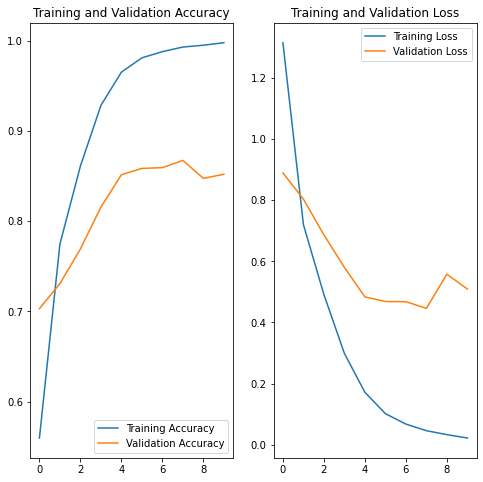

In [17]:
# 학습 결과 보기
acc          = history.history["accuracy"]
val_acc      = history.history["val_accuracy"]
loss         = history.history["loss"]
val_loss     = history.history["val_loss"]
epochs_range = range(len(acc))

plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc,     label = "Training Accuracy")
plt.plot(epochs_range, val_acc, label = "Validation Accuracy")
plt.legend(loc = "lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss,     label = "Training Loss")
plt.plot(epochs_range, val_loss, label = "Validation Loss")
plt.legend(loc = "upper right")
plt.title("Training and Validation Loss")
plt.show()

In [18]:
# model 평가하기
model_wav_skip.load_weights(checkpoint_dir)
results = model_wav_skip.evaluate(test_dataset)

print("loss value : {:.3f}".format(results[0]))
print("accuracy value : {:.4f}%".format(results[1] * 100))

188/188 [==============================] - 8s 40ms/step - loss: 0.4467 - accuracy: 0.8670
loss value : 0.447
accuracy value : 86.7000%


In [19]:
# 직접 모델 테스트 해보기
inv_label_value = {v:k for k, v in label_value.items()}
batch_index     = np.random.choice(len(test_wav), size = 1, replace = False)

batch_xs        = test_wav[batch_index]
batch_ys        = test_label[batch_index]
y_pred          = model_wav_skip(batch_xs, training = False)

print("label :", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(8000,), rate = 8000)

if np.argmax(y_pred) == batch_ys[0]:
    print("y_pred :" + str(inv_label_value[np.argmax(y_pred)]) + "(Correct!)")
else :
    print("y_pred :" + str(inv_label_value[np.argmax(y_pred)]) + "(Incorrect!)")

label : no
y_pred :no(Correct!)


#### 2. 2차원 Spectrogram 데이터를 이용한 모델 만들어서 학습시키기

In [20]:
# 스펙트로그램 데이터 만들기
def wav2spec(wav, fft_size = 258): # spectrogram shape을 맞추기 위해 size 변경
    D = np.abs(librosa.stft(wav, n_fft = fft_size))
    return D

Waveform data shape : (8000,)
Spectrogram data shape : (130, 126)


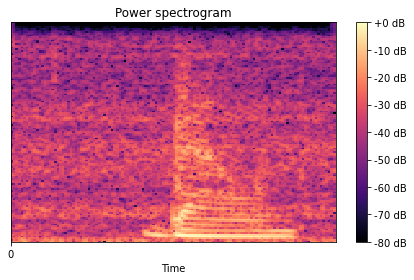

In [21]:
# 위에서 뽑았던 sample data
spec  = wav2spec(data)
# spec_label = wav2spec(label)
print("Waveform data shape :",     data.shape)
# print("Waveform label shape :",    label.shape)
print("Spectrogram data shape :",  spec.shape)
# print("Spectrogram label shape :", spec_label.shape)

librosa.display.specshow(librosa.amplitude_to_db(spec, ref = np.max), x_axis = "time")
plt.title("Power spectrogram")
plt.colorbar(format = "%+2.0f dB")
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()

In [22]:
data_spec = []

for wav in data_speech["wav_vals"][:30000]:
    temp_spec = wav2spec(wav)
    data_spec.append(temp_spec)
    
data_spec = np.array(data_spec)
print("data_spec shape :", data_spec.shape)

data_spec shape : (30000, 130, 126)


In [23]:
sr = (130, 126)
train_spec, test_spec, train_label, test_label = train_test_split(data_spec, label_data, test_size = 0.2, shuffle = True)

In [24]:
batch_size     = 32
max_epochs     = 10
checkpoint_dir = os.getenv('HOME') + '/aiffel/speech_recognition/models/spec'

In [25]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_spec, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size = batch_size)
print(train_dataset)

test_dataset = tf.data.Dataset.from_tensor_slices((test_spec, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size = batch_size)
print(test_dataset)

<BatchDataset shapes: ((None, 130, 126), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 130, 126), (None, 12)), types: (tf.float32, tf.float32)>


In [26]:
# Wave Classification 모델 구현 - 기본 버전
input_tensor  = tf.keras.Input(shape = sr)

# 1계층
model_temp    = tf.keras.layers.Conv1D(32, 9, padding = "same", activation = "relu")(input_tensor)
model_temp    = tf.keras.layers.Conv1D(32, 9, padding = "same", activation = "relu")(model_temp)
model_temp    = tf.keras.layers.MaxPool1D()(model_temp)

# 2계층
model_temp    = tf.keras.layers.Conv1D(64, 9, padding = "same", activation = "relu")(model_temp)
model_temp    = tf.keras.layers.Conv1D(64, 9, padding = "same", activation = "relu")(model_temp)
model_temp    = tf.keras.layers.MaxPool1D()(model_temp)

# 3계층
model_temp    = tf.keras.layers.Conv1D(128, 9, padding = "same", activation = "relu")(model_temp)
model_temp    = tf.keras.layers.Conv1D(128, 9, padding = "same", activation = "relu")(model_temp)
model_temp    = tf.keras.layers.Conv1D(128, 9, padding = "same", activation = "relu")(model_temp)
model_temp    = tf.keras.layers.MaxPool1D()(model_temp)

# 4계층
model_temp    = tf.keras.layers.Conv1D(256, 9, padding = "same", activation = "relu")(model_temp)
model_temp    = tf.keras.layers.Conv1D(256, 9, padding = "same", activation = "relu")(model_temp)
model_temp    = tf.keras.layers.Conv1D(256, 9, padding = "same", activation = "relu")(model_temp)
model_temp    = tf.keras.layers.MaxPool1D()(model_temp)
model_temp    = tf.keras.layers.Dropout(0.3)(model_temp)

# 5계층
model_temp    = tf.keras.layers.Flatten()(model_temp)
model_temp    = tf.keras.layers.Dense(256)(model_temp)
model_temp    = tf.keras.layers.BatchNormalization()(model_temp)
model_temp    = tf.keras.layers.Activation("relu")(model_temp)

output_tensor = tf.keras.layers.Dense(12)(model_temp)

model_spec    = tf.keras.Model(input_tensor, output_tensor)

model_spec.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 130, 126)]        0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 130, 32)           36320     
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 130, 32)           9248      
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 65, 32)            0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 65, 64)            18496     
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 65, 64)            36928     
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 32, 64)            0   

In [27]:
# model compile
model_spec.compile(loss      = tf.keras.losses.CategoricalCrossentropy(from_logits = True), 
                   optimizer = tf.keras.optimizers.Adam(1e-4), 
                   metrics   = ["accuracy"])

# callback 지정하기
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir, 
                                                 save_weights_only = True, 
                                                 monitor           = "val_loss", 
                                                 mode              = "auto", 
                                                 save_best_only    = True,
                                                 verbose           = 1)

# 모델 학습시키기
history = model_spec.fit(train_dataset, 
                         epochs           = max_epochs, 
                         steps_per_epoch  = len(train_spec) // batch_size,
                         validation_data  = test_dataset,
                         validation_steps = len(test_spec) // batch_size,
                         callbacks        = [cp_callback])

Epoch 1/10
743/750 [============================>.] - ETA: 0s - loss: 1.5847 - accuracy: 0.4454
Epoch 00001: val_loss improved from inf to 1.10070, saving model to /home/aiffel-dj52/aiffel/speech_recognition/models/spec
750/750 [==============================] - 5s 7ms/step - loss: 1.5801 - accuracy: 0.4472 - val_loss: 1.1007 - val_accuracy: 0.6075
Epoch 2/10
743/750 [============================>.] - ETA: 0s - loss: 0.8948 - accuracy: 0.6827
Epoch 00002: val_loss improved from 1.10070 to 0.72923, saving model to /home/aiffel-dj52/aiffel/speech_recognition/models/spec
750/750 [==============================] - 5s 7ms/step - loss: 0.8934 - accuracy: 0.6833 - val_loss: 0.7292 - val_accuracy: 0.7447
Epoch 3/10
747/750 [============================>.] - ETA: 0s - loss: 0.5700 - accuracy: 0.8031
Epoch 00003: val_loss improved from 0.72923 to 0.49582, saving model to /home/aiffel-dj52/aiffel/speech_recognition/models/spec
750/750 [==============================] - 5s 7ms/step - loss: 0.5691 

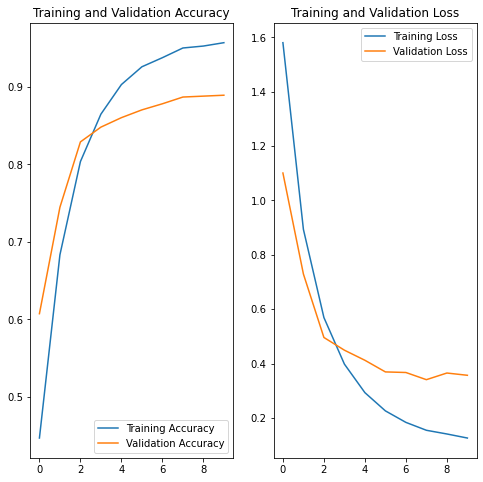

In [28]:
# 학습 결과 보기
acc          = history.history["accuracy"]
val_acc      = history.history["val_accuracy"]
loss         = history.history["loss"]
val_loss     = history.history["val_loss"]
epochs_range = range(len(acc))

plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc,     label = "Training Accuracy")
plt.plot(epochs_range, val_acc, label = "Validation Accuracy")
plt.legend(loc = "lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss,     label = "Training Loss")
plt.plot(epochs_range, val_loss, label = "Validation Loss")
plt.legend(loc = "upper right")
plt.title("Training and Validation Loss")
plt.show()

In [29]:
# model 평가하기
model_spec.load_weights(checkpoint_dir)
results = model_spec.evaluate(test_dataset)

print("loss value : {:.3f}".format(results[0]))
print("accuracy value : {:.4f}%".format(results[1] * 100))

188/188 [==============================] - 19s 99ms/step - loss: 0.3404 - accuracy: 0.8867
loss value : 0.340
accuracy value : 88.6667%


In [30]:
# 직접 모델 테스트 해보기
inv_label_value = {v:k for k, v in label_value.items()}
batch_index     = np.random.choice(len(test_spec), size = 1, replace = False)

batch_xs        = test_spec[batch_index]
batch_ys        = test_label[batch_index]
y_pred          = model_spec(batch_xs, training = False)

print("label :", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(130, 126), rate = 8000)

if np.argmax(y_pred) == batch_ys[0]:
    print("y_pred :" + str(inv_label_value[np.argmax(y_pred)]) + "(Correct!)")
else :
    print("y_pred :" + str(inv_label_value[np.argmax(y_pred)]) + "(Incorrect!)")

label : go
y_pred :go(Correct!)


In [31]:
# Wave Classification 모델 구현 - Skip-connection
input_tensor = tf.keras.layers.Input(shape = sr)

model_temp   = tf.keras.layers.Conv1D(32, 9, padding = 'same', activation = 'relu')(input_tensor)
model_temp   = tf.keras.layers.Conv1D(32, 9, padding = 'same', activation = 'relu')(model_temp)
model_skip_1 = tf.keras.layers.MaxPooling1D()(model_temp)

model_temp   = tf.keras.layers.Conv1D(64, 9, padding = 'same', activation = 'relu')(model_skip_1)
model_temp   = tf.keras.layers.Conv1D(64, 9, padding = 'same', activation = 'relu')(model_temp)
model_temp   = tf.concat([model_temp, model_skip_1], -1)
model_skip_2 = tf.keras.layers.MaxPooling1D()(model_temp)

model_temp   = tf.keras.layers.Conv1D(128, 9, padding = 'same', activation = 'relu')(model_skip_2)
model_temp   = tf.keras.layers.Conv1D(128, 9, padding = 'same', activation = 'relu')(model_temp)
model_temp   = tf.keras.layers.Conv1D(128, 9, padding = 'same', activation = 'relu')(model_temp)
model_temp   = tf.concat([model_temp, model_skip_2], -1)
model_skip_3 = tf.keras.layers.MaxPooling1D()(model_temp)

model_temp   = tf.keras.layers.Conv1D(256, 9, padding = 'same', activation = 'relu')(model_skip_3)
model_temp   = tf.keras.layers.Conv1D(256, 9, padding = 'same', activation = 'relu')(model_temp)
model_temp   = tf.keras.layers.Conv1D(256, 9, padding = 'same', activation = 'relu')(model_temp)
model_temp   = tf.concat([model_temp, model_skip_3], -1)
model_temp   = tf.keras.layers.MaxPooling1D()(model_temp)
model_temp   = tf.keras.layers.Dropout(0.3)(model_temp)

model_temp   = tf.keras.layers.Flatten()(model_temp)
model_temp   = tf.keras.layers.Dense(256)(model_temp)
model_temp   = tf.keras.layers.BatchNormalization()(model_temp)
model_temp   = tf.keras.layers.Activation('relu')(model_temp)

output_tensor = tf.keras.layers.Dense(12)(model_temp)

model_spec_skip = tf.keras.Model(input_tensor, output_tensor)

model_spec_skip.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 130, 126)]   0                                            
__________________________________________________________________________________________________
conv1d_30 (Conv1D)              (None, 130, 32)      36320       input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_31 (Conv1D)              (None, 130, 32)      9248        conv1d_30[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_12 (MaxPooling1D) (None, 65, 32)       0           conv1d_31[0][0]                  
____________________________________________________________________________________________

In [32]:
# model compile
model_spec_skip.compile(loss     = tf.keras.losses.CategoricalCrossentropy(from_logits = True),
                       optimizer = tf.keras.optimizers.Adam(1e-4),
                       metrics   = ["accuracy"])

# callback 지정하기
checkpoint_dir = os.getenv('HOME') + "/aiffel/speech_recognition/models/wav_skip"
cp_callback    = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                    save_weights_only = True,
                                                    monitor           = 'val_loss',
                                                    mode              = 'auto',
                                                    save_best_only    = True,
                                                    verbose           = 1)

# 모델 학습시키기
history = model_spec_skip.fit(train_dataset, epochs = max_epochs,
                             steps_per_epoch        = len(train_spec) // batch_size,
                             validation_data        = test_dataset,
                             validation_steps       = len(test_spec) // batch_size,
                             callbacks              = [cp_callback])

Epoch 1/10
745/750 [============================>.] - ETA: 0s - loss: 1.6385 - accuracy: 0.4314
Epoch 00001: val_loss improved from inf to 1.15044, saving model to /home/aiffel-dj52/aiffel/speech_recognition/models/wav_skip
750/750 [==============================] - 6s 8ms/step - loss: 1.6352 - accuracy: 0.4324 - val_loss: 1.1504 - val_accuracy: 0.6011
Epoch 2/10
750/750 [==============================] - ETA: 0s - loss: 0.9234 - accuracy: 0.6779
Epoch 00002: val_loss improved from 1.15044 to 0.73195, saving model to /home/aiffel-dj52/aiffel/speech_recognition/models/wav_skip
750/750 [==============================] - 6s 8ms/step - loss: 0.9234 - accuracy: 0.6779 - val_loss: 0.7320 - val_accuracy: 0.7442
Epoch 3/10
744/750 [============================>.] - ETA: 0s - loss: 0.6156 - accuracy: 0.7916
Epoch 00003: val_loss improved from 0.73195 to 0.54769, saving model to /home/aiffel-dj52/aiffel/speech_recognition/models/wav_skip
750/750 [==============================] - 6s 7ms/step - l

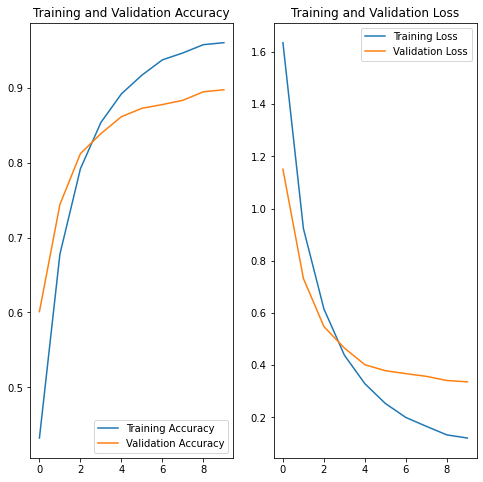

In [33]:
# 학습 결과 보기
acc          = history.history["accuracy"]
val_acc      = history.history["val_accuracy"]
loss         = history.history["loss"]
val_loss     = history.history["val_loss"]
epochs_range = range(len(acc))

plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc,     label = "Training Accuracy")
plt.plot(epochs_range, val_acc, label = "Validation Accuracy")
plt.legend(loc = "lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss,     label = "Training Loss")
plt.plot(epochs_range, val_loss, label = "Validation Loss")
plt.legend(loc = "upper right")
plt.title("Training and Validation Loss")
plt.show()

In [34]:
# model 평가하기
model_spec_skip.load_weights(checkpoint_dir)
results = model_spec_skip.evaluate(test_dataset)

print("loss value : {:.3f}".format(results[0]))
print("accuracy value : {:.4f}%".format(results[1] * 100))

188/188 [==============================] - 5s 28ms/step - loss: 0.3357 - accuracy: 0.8973
loss value : 0.336
accuracy value : 89.7333%


In [35]:
# 직접 모델 테스트 해보기
inv_label_value = {v:k for k, v in label_value.items()}
batch_index     = np.random.choice(len(test_spec), size = 1, replace = False)

batch_xs        = test_spec[batch_index]
batch_ys        = test_label[batch_index]
y_pred          = model_spec_skip(batch_xs, training = False)

print("label :", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(130, 126), rate = 8000)

if np.argmax(y_pred) == batch_ys[0]:
    print("y_pred :" + str(inv_label_value[np.argmax(y_pred)]) + "(Correct!)")
else :
    print("y_pred :" + str(inv_label_value[np.argmax(y_pred)]) + "(Incorrect!)")

label : right
y_pred :right(Correct!)
